<a href="https://colab.research.google.com/github/Jingyi-Z/ThermalZZZ/blob/main/MNIST_thermalzzz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11/13/25 Original Version


In [1]:
! pip install optuna -q
! pip install xlsxwriter
! rm -rf ThermalZZZ
! git clone https://github.com/Jingyi-Z/ThermalZZZ.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 8.2 MB/s eta 0:00:00
Cloning into 'ThermalZZZ'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 27 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 1.01 MiB | 10.60 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [6]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
from importlib_resources import files, as_file
from openpyxl import load_workbook
import pickle
import time
from dataclasses import dataclass, field


from typing import Literal, Optional, Union
from sklearn.linear_model import LinearRegression
from numpy.linalg import matrix_rank
import secrets
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Subset,TensorDataset
from google.colab import drive
import csv
import os

from pylab import *
import xlsxwriter
from tkinter.filedialog import askopenfilename
import matplotlib.font_manager as fm
import optuna
import json, csv, time

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

USE_PIN_MEMORY = torch.cuda.is_available()
data_path = '/content/ThermalZZZ/'

plt.style.use("default")
mpl.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 600,
    "savefig.transparent": True,
    "font.size": 9.5,
    "font.family": 'DejaVu Sans',
    "mathtext.fontset": "dejavusans",
    "axes.linewidth": 0.9,
    "axes.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 4,
    "xtick.minor.size": 2.5,
    "ytick.major.size": 4,
    "ytick.minor.size": 2.5,
    "legend.frameon": True,
    "legend.facecolor": "none",
    "legend.edgecolor": "0.85",
    "legend.framealpha": 0.95,
    "legend.fontsize": 8.5,
})


In [3]:
# Log
LOG_DIR = "/content/logs" # Log in Colab
os.makedirs(LOG_DIR, exist_ok=True)
LOG_PATH = os.path.join(LOG_DIR, "ThermalZZZ_log.csv")  # single rolling log

def _to_scalar(x):
    """Best-effort: convert tensors/ndarrays/scalars to plain python scalars if size==1."""
    try:
        if isinstance(x, torch.Tensor):
            if x.numel() == 1:
                return x.detach().cpu().item()
            return f"<Tensor shape={tuple(x.shape)} dtype={x.dtype}>"
        if isinstance(x, np.ndarray):
            if x.size == 1:
                return x.item()
            return f"<ndarray shape={x.shape} dtype={x.dtype}>"
        if isinstance(x, (np.floating, np.integer)):
            return x.item()
        return x
    except Exception:
        return str(x)

def sanitize_params(p: dict):
    """Make params JSON-serializable without dumping huge arrays."""
    out = {}
    for k, v in p.items():
        if isinstance(v, (int, float, str, bool)) or v is None:
            out[k] = v
        elif isinstance(v, (np.ndarray, torch.Tensor)):
            # store a compact description instead of full data
            if isinstance(v, torch.Tensor):
                out[k] = f"<Tensor shape={tuple(v.shape)} dtype={v.dtype}>"
            else:
                out[k] = f"<ndarray shape={v.shape} dtype={v.dtype}>"
        else:
            # try scalar conversion, otherwise repr
            sv = _to_scalar(v)
            out[k] = sv if isinstance(sv, (int, float, str, bool)) or sv is None else repr(v)
    return out

def append_run_log(
    log_path: str,
    params, # params
    loss_train_per_epoch: list,
    acc_train_per_epoch: list,
    t_tot: float,
    t_per_epoch: float,
    acc_test: float,
    acc_test_95CI_low: float,
    acc_test_95CI_high: float,
    t_inf: float,
):
    """Append one row to CSV (create with header if missing)."""
    ts = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    row = {
        "timestamp": ts,
        "params_json": json.dumps(sanitize_params(vars(params)), ensure_ascii=False),
        "loss_train": json.dumps([_to_scalar(x) for x in loss_train_per_epoch]),
        "acc_train": json.dumps([_to_scalar(x) for x in acc_train_per_epoch]),
        "t_tot": float(t_tot),
        "t_per_epoch": float(t_per_epoch),
        "acc_test": float(acc_test),
        "acc_test_95CI_low":float(acc_test_95CI_low),
        "acc_test_95CI_high":float(acc_test_95CI_high),
        "t_inf": float(t_inf),
    }

    df = pd.DataFrame([row])
    # Create with header if not exists; else append without header
    if not os.path.exists(log_path):
        df.to_csv(log_path, index=False)
    else:
        df.to_csv(log_path, index=False, mode="a", header=False)

    print(f"Appended run to: {log_path}")

# Voltage-temperature mapping

In [ ]:
def data_to_mapping(file_name = "Data_thermalzzz.xlsx", sheet_name = "mapping4"):
  df_temp = pd.read_excel(data_path+file_name, sheet_name = sheet_name, header = None, dtype={0: object})
  display(df_temp)
  mapping_temp = dict(zip(df_temp.iloc[:,0], df_temp.iloc[:,1:].apply(list, axis=1)))
  print(mapping_temp)

  # Preprocessing: feature (0,1)
  df_temp_norm = df_temp.copy()
  scaler = MinMaxScaler(feature_range=(0, 1))
  df_temp_norm.iloc[:,1:] = scaler.fit_transform(df_temp_norm.iloc[:,1:])
  display(df_temp_norm)
  mapping_temp_norm = dict(zip(df_temp_norm.iloc[:,0], df_temp_norm.iloc[:,1:].apply(list, axis=1)))
  print(mapping_temp_norm)

  return mapping_temp, mapping_temp_norm, df_temp, df_temp_norm

## 4 pulse -> 4 Temp

,0,1,2,3,4
0,0000,300.150000,300.150000,300.150000,300.150000
1,0001,300.150000,300.150000,300.289987,315.305835
2,0010,300.150000,300.289177,314.825232,304.049589
3,0011,300.150000,300.289177,315.304010,319.108461
4,0100,300.291997,314.841703,304.028226,302.095238
5,0101,300.291997,314.841703,303.848357,317.019959
6,0110,300.291997,315.289371,318.252399,305.841699
7,0111,300.291997,315.289371,319.105658,321.008318
8,1000,314.639033,303.991243,302.086899,301.401418
9,1001,314.639033,303.991243,302.141510,316.430589


{'0000': [300.150000000003, 300.150000000004, 300.150000000004, 300.150000000003], '0001': [300.150000000003, 300.150000000003, 300.289986506597, 315.305834939071], '0010': [300.150000000003, 300.28917742438, 314.825232174898, 304.04958941437], '0011': [300.150000000003, 300.289177424379, 315.304010462959, 319.108460886403], '0100': [300.29199748333, 314.841703355162, 304.028225780774, 302.09523780549], '0101': [300.29199748333, 314.841703355159, 303.848356603222, 317.019959125918], '0110': [300.29199748333, 315.289370910832, 318.252398897387, 305.84169927821], '0111': [300.29199748333, 315.289370910832, 319.10565802357, 321.008317692269], '1000': [314.639033466648, 303.991242670541, 302.086899013192, 301.401418245678], '1001': [314.639033466649, 303.991242670541, 302.141509998174, 316.430589343692], '1010': [314.639033466649, 303.8120435623, 316.508695289682, 305.236830706881], '1011': [314.639033466637, 303.812043562412, 317.013273202063, 320.296709807373], '1100': [315.318220437372,

,0,1,2,3,4
0,0000,0.000000,5.329071e-14,0.000000,0.000000
1,0001,0.000000,0.000000e+00,0.006707,0.684340
2,0010,0.000000,7.338094e-03,0.703137,0.176080
3,0011,0.000000,7.338094e-03,0.726077,0.856043
4,0100,0.009362,7.746163e-01,0.185818,0.087834
5,0101,0.009362,7.746163e-01,0.177200,0.761739
6,0110,0.009362,7.982195e-01,0.867343,0.257001
7,0111,0.009362,7.982195e-01,0.908226,0.941828
8,1000,0.955223,2.025285e-01,0.092803,0.056506
9,1001,0.955223,2.025285e-01,0.095420,0.735127


{'0000': [0.0, 5.3290705182007514e-14, 0.0, 0.0], '0001': [0.0, 0.0, 0.006707196537094617, 0.6843404025262547], '0010': [0.0, 0.007338094477004731, 0.703136815255343, 0.1760804733123571], '0011': [0.0, 0.007338094476949664, 0.7260765981949646, 0.8560426269115222], '0100': [0.00936151237472771, 0.7746163411979765, 0.1858180703264729, 0.08783447617160078], '0101': [0.00936151237472771, 0.7746163411978202, 0.17719996880962618, 0.7617392684233089], '0110': [0.00936151237472771, 0.7982194997741665, 0.8673432186622048, 0.25700067272876304], '0111': [0.00936151237472771, 0.7982194997741665, 0.9082255636514898, 0.9418279878959641], '1000': [0.9552230287311261, 0.20252854765549344, 0.09280296130061494, 0.056506030147263075], '1001': [0.95522302873119, 0.20252854765549344, 0.09541954641494677, 0.7351271051458088], '1010': [0.95522302873119, 0.19308032002552267, 0.7837968606312593, 0.22968868343599702], '1011': [0.9552230287304013, 0.19308032003142372, 0.8079727852184497, 0.9096963350805041], '11

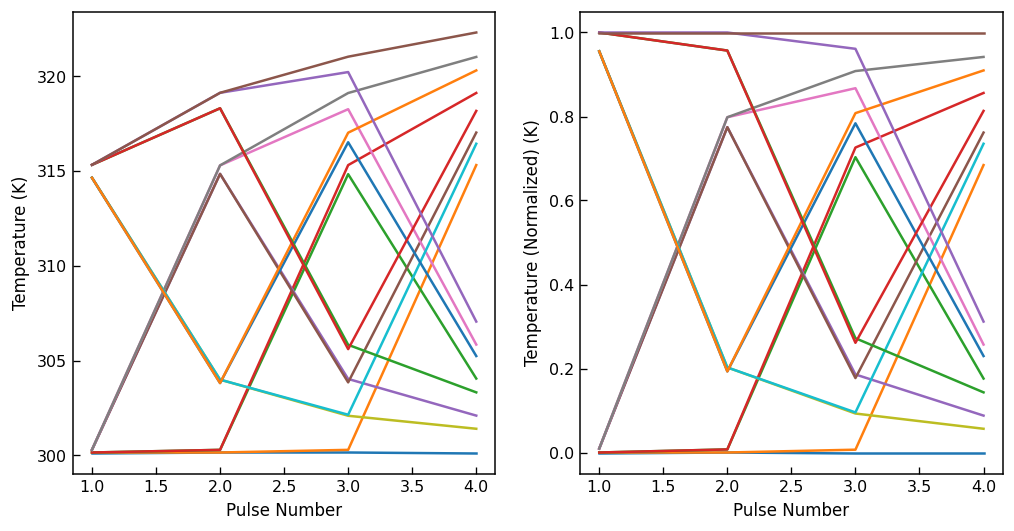

In [9]:
mapping_4temp, mapping_4temp_norm, df_4temp, df_4temp_norm = data_to_mapping(sheet_name = "mapping4")

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
for i in range (df_4temp.shape[0]):
  plt.plot(df_4temp.iloc[i,1:],label = df_4temp.iloc[i,0])
plt.xlabel("Pulse Number")
plt.ylabel("Temperature (K)")

plt.subplot(1,2,2)
for i in range (df_4temp_norm.shape[0]):
  plt.plot(df_4temp_norm.iloc[i,1:],label = df_4temp_norm.iloc[i,0])
plt.xlabel("Pulse Number")
plt.ylabel("Temperature (Normalized) (K)")

plt.show()


## 4 pulse -> 20 Temp

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0000,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,...,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000
1,0001,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,...,300.150000,300.150000,300.150000,300.150000,300.289987,306.723550,310.096333,312.299152,313.974315,315.305835
2,0010,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,...,306.718079,310.090440,312.296024,314.277404,314.825232,309.990357,307.577788,305.942011,304.938017,304.049589
3,0011,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,300.150000,...,306.718079,310.090440,312.296024,313.971126,315.304010,316.357354,317.233162,317.955540,318.578135,319.108461
4,0100,300.150000,300.150000,300.150000,300.150000,300.150000,300.291997,306.678241,310.085839,312.271168,...,309.988775,307.580760,305.901602,304.938987,304.028226,303.479052,302.957070,302.625150,302.308120,302.095238
5,0101,300.150000,300.150000,300.150000,300.150000,300.150000,300.291997,306.678241,310.085839,312.271168,...,309.988775,307.580760,305.840609,304.659914,303.848357,309.437364,312.496112,314.388754,315.889720,317.019959
6,0110,300.150000,300.150000,300.150000,300.150000,300.150000,300.291997,306.678241,310.085839,312.271168,...,316.353503,317.223820,317.952263,318.571707,318.252399,312.875800,310.067761,308.155615,306.915324,305.841699
7,0111,300.150000,300.150000,300.150000,300.150000,300.150000,300.291997,306.678241,310.085839,312.271168,...,316.353503,317.223820,317.952263,318.571707,319.105658,319.574380,319.988890,320.362142,320.699046,321.008318
8,1000,300.170898,306.715708,310.003093,312.307643,313.943847,314.639033,309.855731,307.487308,305.834038,...,303.451199,302.936608,302.609765,302.296866,302.086899,301.884924,301.741955,301.603789,301.501088,301.401418
9,1001,300.170898,306.715708,310.003093,312.307643,313.943847,314.639033,309.855731,307.487308,305.834038,...,303.451199,302.936608,302.609765,302.288157,302.141510,308.215535,311.641445,313.553354,315.285992,316.430589


{'0000': [300.15, 300.150000000003, 300.150000000002, 300.150000000002, 300.150000000002, 300.150000000003, 300.150000000003, 300.150000000003, 300.150000000003, 300.150000000003, 300.150000000004, 300.150000000003, 300.150000000003, 300.150000000003, 300.150000000004, 300.150000000004, 300.150000000003, 300.150000000004, 300.150000000003, 300.150000000002, 300.150000000003], '0001': [300.15, 300.150000000003, 300.150000000002, 300.150000000003, 300.150000000003, 300.150000000003, 300.150000000002, 300.150000000003, 300.150000000003, 300.150000000003, 300.150000000003, 300.150000000003, 300.150000000003, 300.150000000004, 300.150000000004, 300.289986506597, 306.723549675454, 310.09633329153, 312.299151534958, 313.974314596283, 315.305834939071], '0010': [300.15, 300.150000000002, 300.150000000002, 300.150000000002, 300.150000000003, 300.150000000003, 300.150000000003, 300.150000000002, 300.150000000002, 300.150000000002, 300.28917742438, 306.718078805801, 310.090440118751, 312.29602369

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0000,0.0,1.421085e-13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,6.039613e-14,5.684342e-14,5.329071e-14,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0001,0.0,1.421085e-13,0.000000e+00,7.815970e-14,7.105427e-14,0.000000,0.000000e+00,5.684342e-14,5.329071e-14,...,0.000000,0.000000,5.151435e-14,0.000000,0.006707,0.310769,0.464203,0.560348,0.630620,0.684340
2,0010,0.0,0.000000e+00,0.000000e+00,0.000000e+00,7.105427e-14,0.000000,6.039613e-14,0.000000e+00,0.000000e+00,...,0.337847,0.500768,6.004975e-01,0.687120,0.703137,0.465209,0.346661,0.267141,0.218414,0.176080
3,0011,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.243450e-13,5.684342e-14,5.329071e-14,...,0.337847,0.500768,6.004975e-01,0.672224,0.726077,0.766213,0.797284,0.821234,0.840632,0.856043
4,0100,0.0,1.421085e-13,9.947598e-14,0.000000e+00,7.105427e-14,0.009362,4.029072e-01,5.811390e-01,6.805811e-01,...,0.506084,0.374338,2.843583e-01,0.232924,0.185818,0.157383,0.131008,0.114160,0.098446,0.087834
5,0101,0.0,1.421085e-13,0.000000e+00,7.815970e-14,1.456613e-13,0.009362,4.029072e-01,5.811390e-01,6.805811e-01,...,0.506084,0.374338,2.813428e-01,0.219350,0.177200,0.439066,0.576203,0.656725,0.717995,0.761739
6,0110,0.0,1.421085e-13,3.019807e-13,1.634248e-13,7.105427e-14,0.009362,4.029072e-01,5.811390e-01,6.805811e-01,...,0.833471,0.860126,8.801411e-01,0.895984,0.867343,0.601621,0.462870,0.369238,0.308612,0.257001
7,0111,0.0,0.000000e+00,9.947598e-14,7.815970e-14,0.000000e+00,0.009362,4.029072e-01,5.811390e-01,6.805811e-01,...,0.833471,0.860126,8.801411e-01,0.895984,0.908226,0.918300,0.925896,0.932232,0.937381,0.941828
8,1000,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.955223,5.990142e-01,4.291531e-01,3.191481e-01,...,0.169806,0.140381,1.216104e-01,0.104418,0.092803,0.082020,0.074298,0.067052,0.061632,0.056506
9,1001,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.955223,5.990142e-01,4.291531e-01,3.191481e-01,...,0.169806,0.140381,1.216104e-01,0.103994,0.095420,0.381303,0.536315,0.618195,0.690455,0.735127


{'0000': [0.0, 1.4210854715202004e-13, 0.0, 0.0, 0.0, 0.0, 6.039613253960852e-14, 5.684341886080802e-14, 5.3290705182007514e-14, 4.973799150320701e-14, 5.3290705182007514e-14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '0001': [0.0, 1.4210854715202004e-13, 0.0, 7.815970093361102e-14, 7.105427357601002e-14, 0.0, 0.0, 5.684341886080802e-14, 5.3290705182007514e-14, 4.973799150320701e-14, 0.0, 0.0, 0.0, 5.1514348342607263e-14, 0.0, 0.006707196537094617, 0.3107688951053422, 0.46420304532709267, 0.5603479295887404, 0.6306204903779875, 0.6843404025262547], '0010': [0.0, 0.0, 0.0, 0.0, 7.105427357601002e-14, 0.0, 6.039613253960852e-14, 0.0, 0.0, 0.0, 0.007338094477004731, 0.3378467146247548, 0.5007682517160177, 0.6004975012960756, 0.6871202607705627, 0.703136815255343, 0.46520938123113886, 0.3466605854920548, 0.26714139283564187, 0.21841383447837792, 0.1760804733123571], '0011': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2434497875801753e-13, 5.684341886080802e-14, 5.3290705182007514e-14, 4.9737

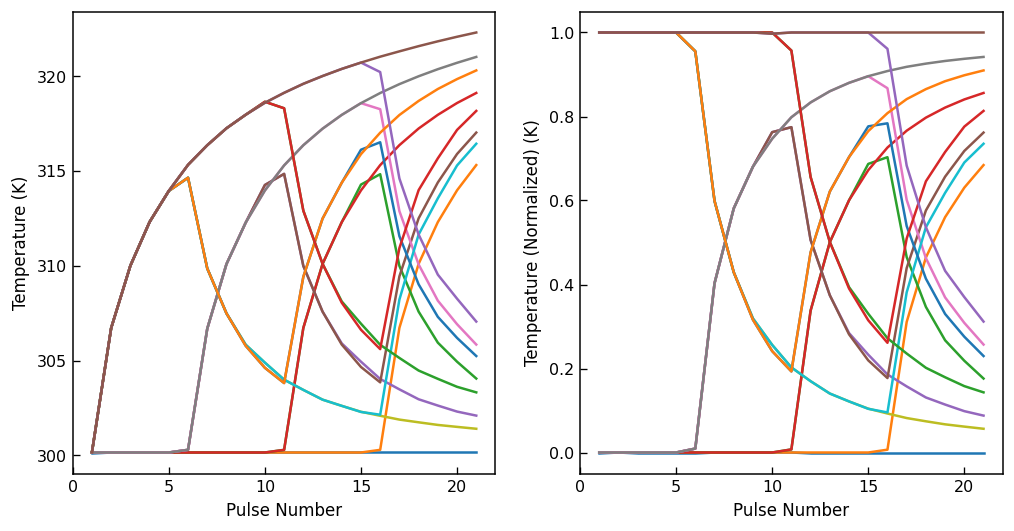

In [10]:
mapping_20temp, mapping_20temp_norm, df_20temp, df_20temp_norm = data_to_mapping(sheet_name = "mapping20")

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
for i in range (df_20temp.shape[0]):
  plt.plot(df_20temp.iloc[i,1:],label = df_20temp.iloc[i,0])
plt.xlabel("Pulse Number")
plt.ylabel("Temperature (K)")

plt.subplot(1,2,2)
for i in range (df_20temp_norm.shape[0]):
  plt.plot(df_20temp_norm.iloc[i,1:],label = df_20temp_norm.iloc[i,0])
plt.xlabel("Pulse Number")
plt.ylabel("Temperature (Normalized) (K)")

plt.show()


# Reservoir layer and output layer

In [13]:
@dataclass
class Params:
    mapping: dict # voltage-temp mapping (string -> list)
    vpulse_len: int = 4 # number of pulses in the mapping (default: 4)
    temp_len: int = 4  # number of measured temperature states in the mapping (default: 4/20)
    test_size: int = 10000 # test set size
    train_size: int = 60000 # training set size
    num_epochs: int = 30 # number of training epochs
    batch_size: int = 64 # batch size
    lr: float = 0.0001 # learning rate

class ThermalReservoirLayer(nn.Module):
    def __init__(self, p: Params, img_size:int = 576): # MNIST preprocessed image (24*24)
        super().__init__()
        self.p = p
        self.img_size = img_size

        assert self. img_size % self.p.vpulse_len == 0, \
        f"Error: img_size ({self.img_size}) must be exactly divisible by vpulse_len ({self.p.vpulse_len})."
        self.input_size = self. img_size // self.p.vpulse_len
        self.seq_len = self.p.vpulse_len
        self.temp_len = self.p.temp_len

        mapping_tensor = torch.zeros((2**self.seq_len, self.temp_len))
        for i in range(2**self.seq_len):
            key = f'{i:0{self.seq_len}b}'
            value = self.p.mapping.get(key, [0.0] * self.temp_len)      # Fallback to zeros
            mapping_tensor[i] = torch.tensor(value)

        self.register_buffer("mapping_tensor", mapping_tensor)
        self.register_buffer("bit_weights", (2 ** torch.arange(self.seq_len - 1, -1, -1)))  # [128, 64, ..., 1]

    def forward(self, x):
        # x shape: (batch_size, seq_len = self.p.vpulse_len, input_size = self.input_size)
        batch_size, _, _ = x.size()
        device = x.device

        # Initial reservoir state
        h_t = torch.zeros(batch_size, self.temp_len, self.input_size, device=device)

        x = x.permute(0, 2, 1)  # [batch, input, seq_len]
        x = x.reshape(-1, self.seq_len)  # [batch * input, seq_len]
        indices = torch.matmul(x, self.bit_weights.int().to(x.device))  # [batch * input]
        responses = self.mapping_tensor[indices] #[batch*input, temp_len]
        h_t = responses.reshape(batch_size, self.input_size, self.temp_len).permute(0, 2, 1) #[batch, temp_len, input_size]
        return h_t # Final reservoir state used for classification

class ThermalReservoirNet(nn.Module):
    def __init__(self, p:Params, img_size:int = 576, output_size:int = 10):
        super().__init__()
        self.reservoir = ThermalReservoirLayer(p, img_size)
        self.readout = nn.Linear(p.temp_len*(img_size//p.vpulse_len), output_size)

    def forward(self, x):
        reservoir_state = self.reservoir(x)
        reservoir_state_reshaped = torch.reshape(reservoir_state, \
         (reservoir_state.size(dim=0),-1))
        out = self.readout(reservoir_state_reshaped)
        return out

# MNIST Classification

In [22]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

p = Params(
    mapping = mapping_4temp_norm,
    vpulse_len = len(next(iter(p.mapping))), # number of pulses in the mapping (default: 4)
    temp_len = len(next(iter(p.mapping))),  # number of measured temperature states in the mapping (default: 4/20)
    test_size = 10000, # test set size
    train_size = 60000, # training set size
    num_epochs = 30, # number of training epochs
    batch_size = 64, # batch size
    lr = 0.0001, # learning rate
    )

# Prepare MNIST Dataset
def preprocess_image(tensor_img, threshold = 20):
    # tensor_img shape: [1, 28, 28], values in [0.0, 1.0]
    tensor_img = tensor_img.squeeze(0)*255
    binary_img = (tensor_img > threshold).int() # binarization
    cropped = binary_img[2:-2,2:-2] # crop the image to size [24,24]
    reshaped = cropped.reshape(p.vpulse_len,int(576/p.vpulse_len))
    return reshaped

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: preprocess_image(x))
])

train_dataset = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=p.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=p.batch_size)

thermal_model = ThermalReservoirNet(p).to(device)
optimizer = torch.optim.Adam(thermal_model.readout.parameters(), lr=p.lr)  # Only train readout

loss_train_hist = []
acc_train_hist = []

criterion = nn.CrossEntropyLoss()
start_time = time.time()

for epoch in range(p.num_epochs):
    thermal_model.train()
    total_loss = 0
    correct = 0
    total = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = thermal_model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    acc = correct / total
    loss_train_hist.append(total_loss)
    acc_train_hist.append(acc)
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Accuracy: {acc*100:.2f}%")

end_time = time.time()
t_total = end_time - start_time
t_per_epoch = t_total / p.num_epochs

print(f"Total training time: {t_total:.2f} seconds")
print(f"Training time per epoch: {t_per_epoch:.2f} seconds")

Epoch 1 | Loss: 1349.4916 | Accuracy: 69.87%
Epoch 2 | Loss: 743.4270 | Accuracy: 82.81%
Epoch 3 | Loss: 567.1949 | Accuracy: 85.41%
Epoch 4 | Loss: 483.3027 | Accuracy: 86.86%
Epoch 5 | Loss: 434.5703 | Accuracy: 87.72%
Epoch 6 | Loss: 402.7296 | Accuracy: 88.35%
Epoch 7 | Loss: 380.3200 | Accuracy: 88.91%
Epoch 8 | Loss: 363.8234 | Accuracy: 89.27%
Epoch 9 | Loss: 350.9958 | Accuracy: 89.56%
Epoch 10 | Loss: 340.8953 | Accuracy: 89.81%
Epoch 11 | Loss: 332.6774 | Accuracy: 90.00%
Epoch 12 | Loss: 325.7434 | Accuracy: 90.17%
Epoch 13 | Loss: 319.8078 | Accuracy: 90.30%
Epoch 14 | Loss: 314.8415 | Accuracy: 90.44%
Epoch 15 | Loss: 310.3379 | Accuracy: 90.55%
Epoch 16 | Loss: 306.4877 | Accuracy: 90.64%
Epoch 17 | Loss: 302.9813 | Accuracy: 90.73%
Epoch 18 | Loss: 299.9912 | Accuracy: 90.80%
Epoch 19 | Loss: 297.0444 | Accuracy: 90.89%
Epoch 20 | Loss: 294.5517 | Accuracy: 90.96%
Epoch 21 | Loss: 292.2131 | Accuracy: 91.00%
Epoch 22 | Loss: 289.9316 | Accuracy: 91.11%
Epoch 23 | Loss: 2

Test Accuracy: 91.69% | Inference time: 2.42 seconds
Test Accuracy (95% CI): 91.15% - 92.23%


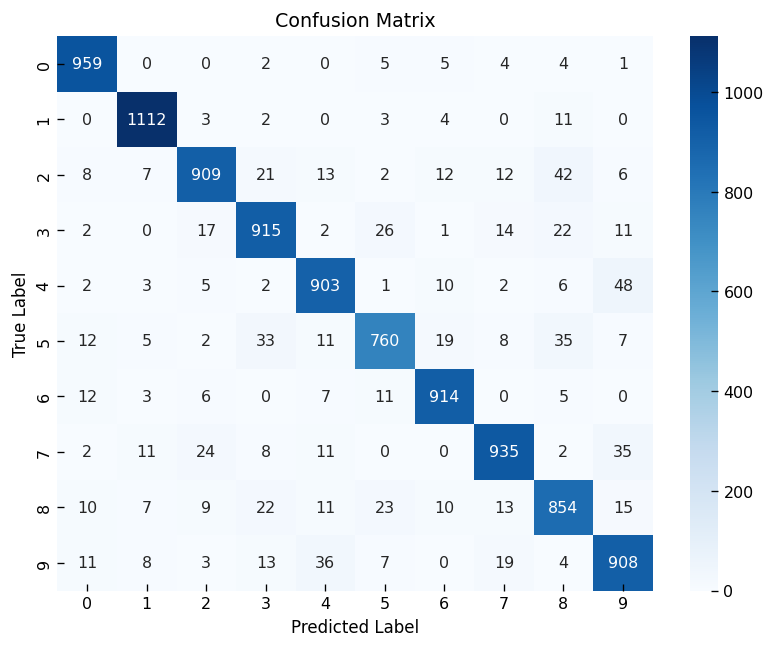

Appended run to: /content/logs/ThermalZZZ_log.csv


In [23]:
# Evaluation
all_preds = []
all_labels = []

thermal_model.eval()  # set model to evaluation mode
tic = time.time()

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = thermal_model(x)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Inference time
t_inf = time.time()-tic

# Accuracy
acc_test = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {acc_test * 100:.2f}% | Inference time: {t_inf:.2f} seconds")

# Accuracy (95% Confidence Interval)
SE_test = np.sqrt(acc_test * (1 - acc_test) / len(all_labels))
z_score = 1.96  # 95% confidence interval
CI_test = (acc_test - z_score * SE_test, acc_test + z_score * SE_test)
print(f"Test Accuracy (95% CI): {CI_test[0]*100:.2f}% - {CI_test[1]*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

append_run_log(
    LOG_PATH,
    params = p,
    loss_train_per_epoch=loss_train_hist,
    acc_train_per_epoch=acc_train_hist,
    t_tot=t_total,
    t_per_epoch=t_per_epoch,
    acc_test=acc_test,
    acc_test_95CI_low=CI_test[0],
    acc_test_95CI_high=CI_test[1],
    t_inf=t_inf,
)